In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_raw=pd.read_csv("/home/piai/바탕화면/2. Big Data 분석/Concrete.csv")
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


#### concrete 데이터를 불러왔습니다.

In [3]:
df_raw.describe()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


#### describe를 통하여 각 변수별로 기술통계량을 확인해주었습니다. 

<Axes: >

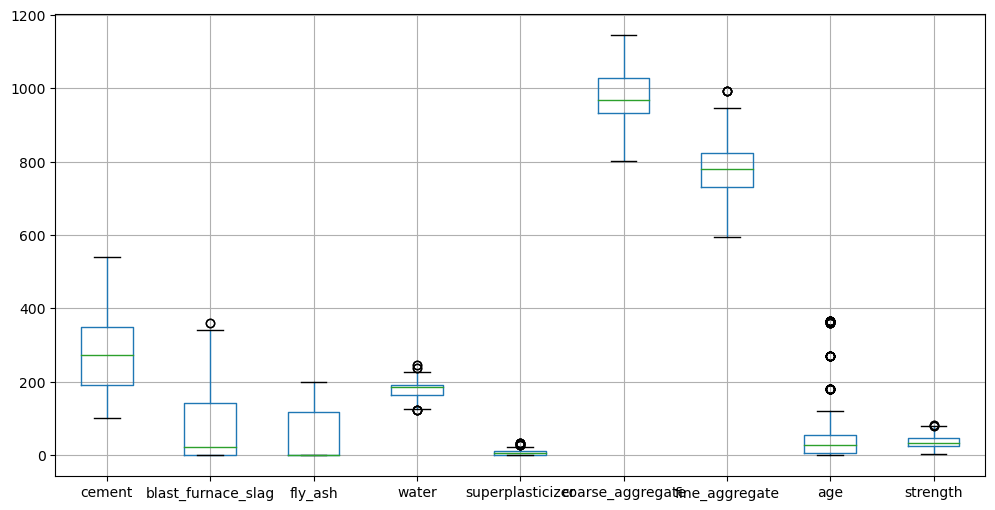

In [4]:
df_raw.boxplot(figsize=(12,6))

#### 각 변수의 boxplot을 그려보았습니다. water변수가 이상치가 있다고 판단되지만, 이번 과제에서는 이상치 처리없이 의사결정나무 모델 구축을 진행해보았습니다.

In [5]:
df_raw.isnull().sum() 

cement                0
blast_furnace_slag    0
fly_ash               0
water                 0
superplasticizer      0
coarse_aggregate      0
fine_aggregate        0
age                   0
strength              0
dtype: int64

#### 각 변수별로 결측치를 확인하였을 때, 결측치는 하나도 없다는 것을 확인하였습니다.

In [6]:
df_raw_y=df_raw["strength"]
df_raw_x=df_raw.drop("strength", axis=1, inplace=False)

In [7]:
df_train_x,df_test_x,df_train_y,df_test_y= train_test_split(df_raw_x, df_raw_y
                                                            , test_size=0.4, random_state=6659)
print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(618, 8)
train data Y size:(618,)
test data X size:(412, 8)
test data Y size:(412,)


In [8]:
tree_uncustomized=DecisionTreeRegressor(random_state=6659)
tree_uncustomized.fit(df_train_x,df_train_y)

print("Score on training set: {:.3f}".format(tree_uncustomized.score(df_train_x,df_train_y)))
print("Score on testing set: {:.3f}".format(tree_uncustomized.score(df_test_x,df_test_y)))


Score on training set: 0.997
Score on testing set: 0.805


#### 모델을 생성해주었습니다. 모델 설명력이 train은 99.7%, test 80.5%로 모델이 train 데이터에 과적합 위험이 존재합니다.

In [9]:
tree_uncustomized.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 6659,
 'splitter': 'best'}

#### 현재 생성된 Tree 모델의 옵션을 확인하였을 때, min_samples_leaf가 1로 된 것을 확인하였습니다. 과적합 위험이 있어 다시 돌려줄 것입니다.

In [10]:
train_score=[]; test_score=[]
para_leaf=[n_leaf for n_leaf in range(1,20)]

for v_min_samples_leaf in para_leaf :
    tree= DecisionTreeRegressor(random_state=6659, min_samples_leaf=v_min_samples_leaf)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

#### min_samples_leaf의 잎사귀 노드의 최소 자료 수를 for문을 통해 1~20번을 순차적으로 돌려보았습니다.

In [11]:
df_score_leaf= pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]= train_score
df_score_leaf["TestScore"]=test_score

#### 데이터 프레임을 만들고 leaf의 파라미터별로 train, test의 score를 확인해주었습니다.

In [12]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,1,0.997,0.805
1,2,0.978,0.813
2,3,0.955,0.826
3,4,0.932,0.821
4,5,0.918,0.823
5,6,0.904,0.824
6,7,0.889,0.819
7,8,0.881,0.812
8,9,0.870,0.801
9,10,0.859,0.774


#### Test 스코어가 가장 크면서 과적합이 아니라고 판단되는 min_samples_leaf = 8를 선정해주었습니다.

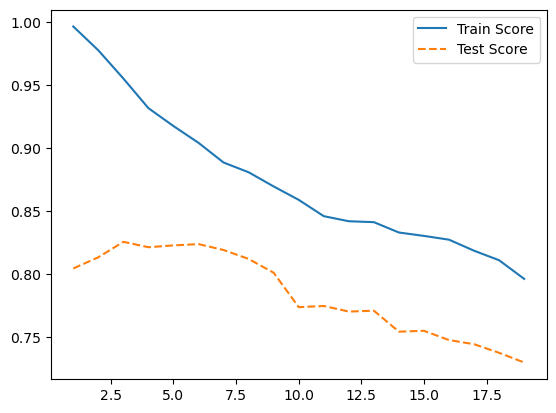

In [13]:
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label="Test Score")
plt.legend()
plt.show()

#### plt.plot을 통해서 leaf 파라미터별로 train, test 스코어를 확인해주었습니다.

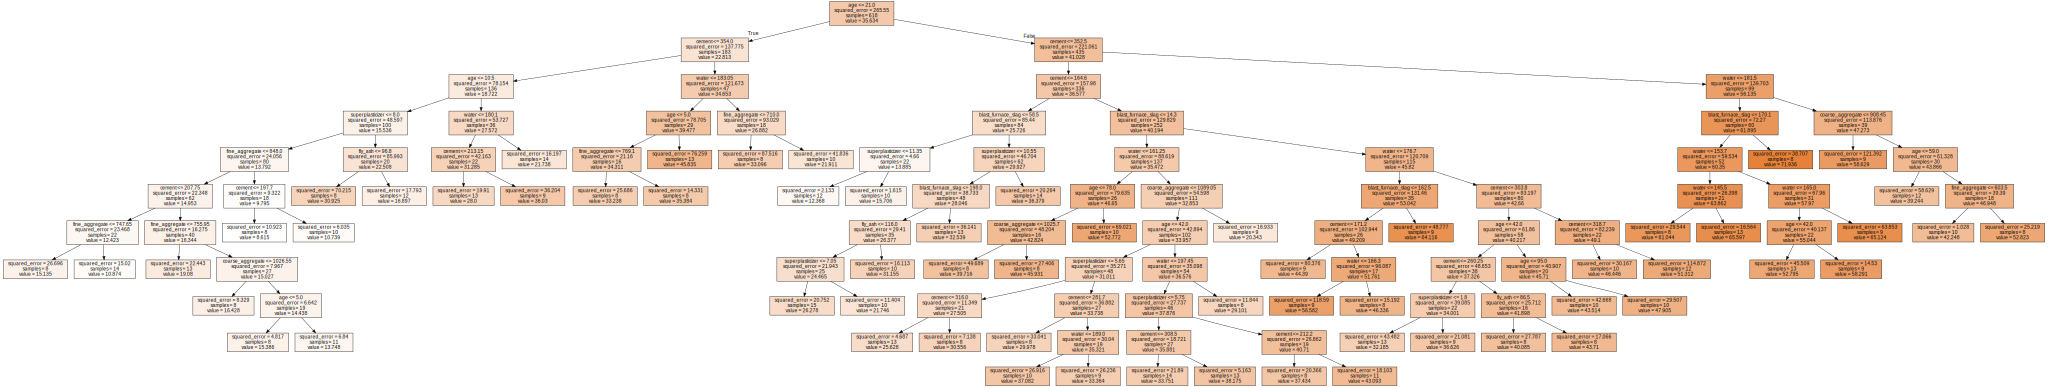

In [14]:
v_feature_name= df_train_x.columns
tree_graph = DecisionTreeRegressor(random_state=6659, min_samples_leaf=8)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names= v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### min_samples_leaf= 8 일 때 전체 트리 구조와 조건문이 쓰인 개수를 확인할 수 있었습니다.

In [15]:
train_score=[]; test_score=[]
para_split=[n_split*2 for n_split in range(2,20)]

for v_min_samples_split in para_split :
    tree= DecisionTreeRegressor(random_state=6659, min_samples_leaf=8,min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

In [16]:
df_score_split= pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]= train_score
df_score_split["TestScore"]=test_score
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.881,0.812
1,6,0.881,0.812
2,8,0.881,0.812
3,10,0.881,0.812
4,12,0.881,0.812
5,14,0.881,0.812
6,16,0.881,0.812
7,18,0.877,0.803
8,20,0.869,0.793
9,22,0.861,0.783


#### 2~20까지 for문을 돌려 n_split*2 에  맞는  min_samples_split값에 따른 train, test score를 확인해주었습니다. 0.891과 0.792가 반복되는 지점을 빼고,  그 다음 값인 18을 지정해주었습니다.

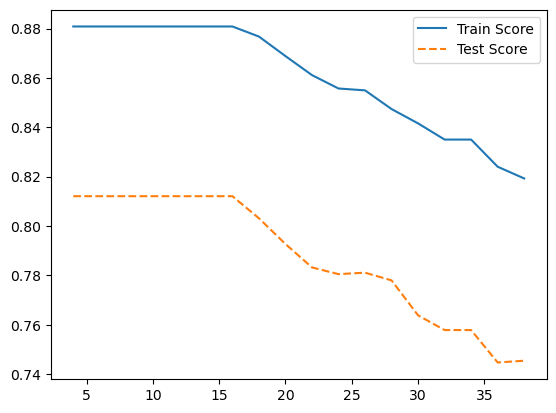

In [17]:
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, test_score, linestyle="--", label="Test Score")
plt.legend()
plt.show()

#### min_samples_split 값은  약 18까지 같은 성능이 반복되고 , 꺾이는 구간인 22를 선정하였습니다. 

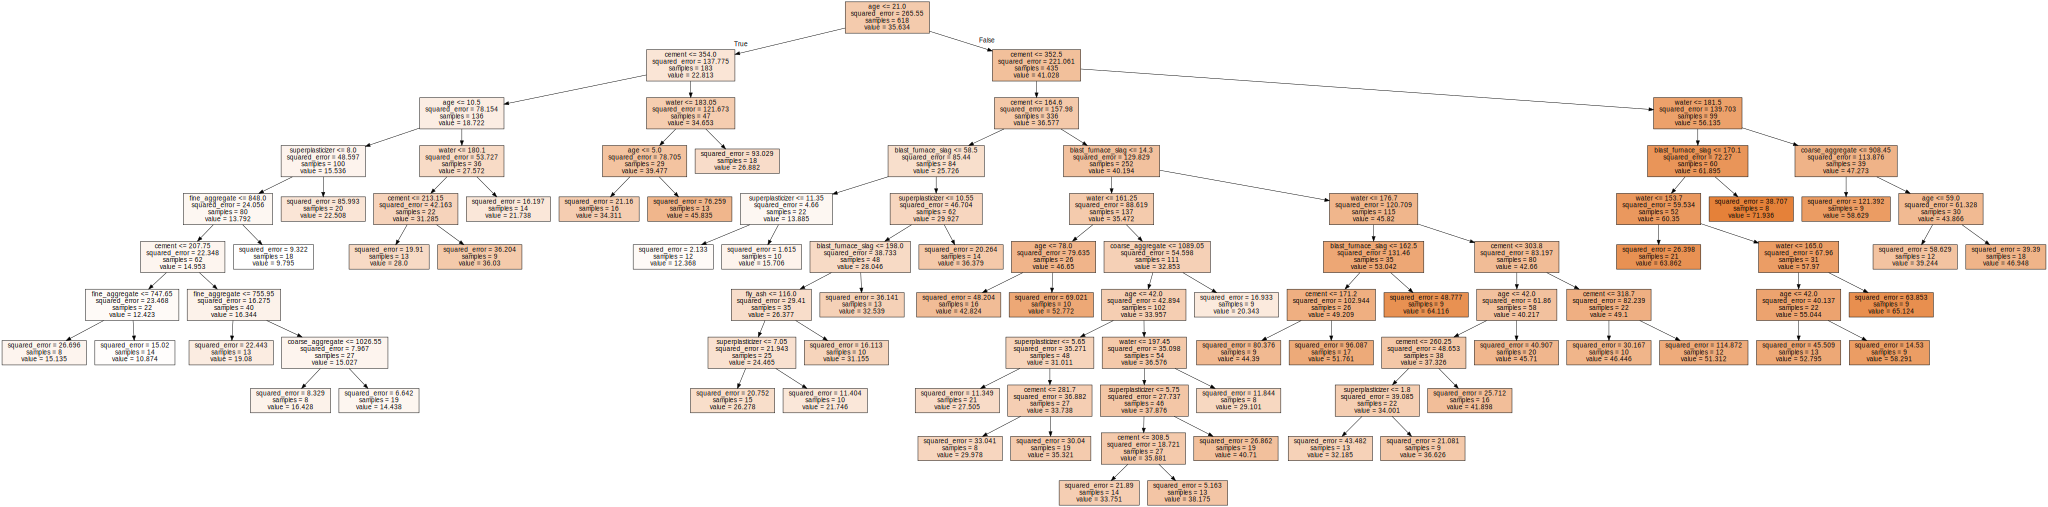

In [18]:
tree_graph = DecisionTreeRegressor(random_state=6659, min_samples_leaf=8, min_samples_split=22)
tree_graph.fit(df_train_x,df_train_y)
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names= v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### min_samples_split=22 추가해서 전체 tree 구조를 한번 더 확인해주었습니다.

In [19]:
train_score=[]; test_score=[]
para_depth=[depth for depth in range(1,11)]

for v_max_depth in para_depth :
    tree= DecisionTreeRegressor(random_state=6659, min_samples_leaf=8,min_samples_split=22, max_depth=v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x,df_train_y))
    test_score.append(tree.score(df_test_x,df_test_y))

In [20]:
df_score_depth= pd.DataFrame()
df_score_depth["depth"]=para_depth
df_score_depth["TrainScore"]= train_score
df_score_depth["TestScore"]=test_score

In [21]:
df_score_depth.round(3)

,depth,TrainScore,TestScore
0,1,0.260,0.229
1,2,0.493,0.471
2,3,0.638,0.599
3,4,0.737,0.675
4,5,0.792,0.725
5,6,0.829,0.760
6,7,0.847,0.774
7,8,0.857,0.777
8,9,0.860,0.782
9,10,0.861,0.783


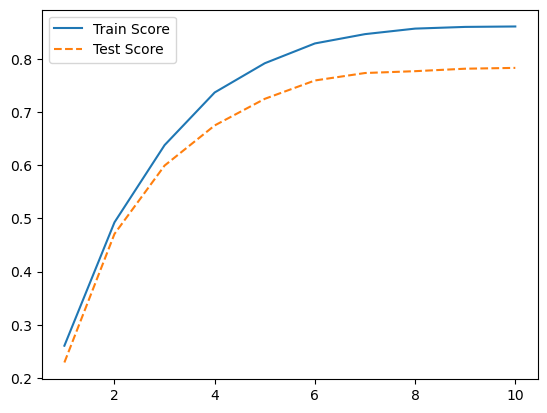

In [22]:
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, test_score, linestyle="--", label="Test Score")
plt.legend()
plt.show()

#### max_depth는 값이 커질수록 높게 나왔고, 6이 적당한 값이라고 판단하여서 max_depth은 6을 선정하였습니다.

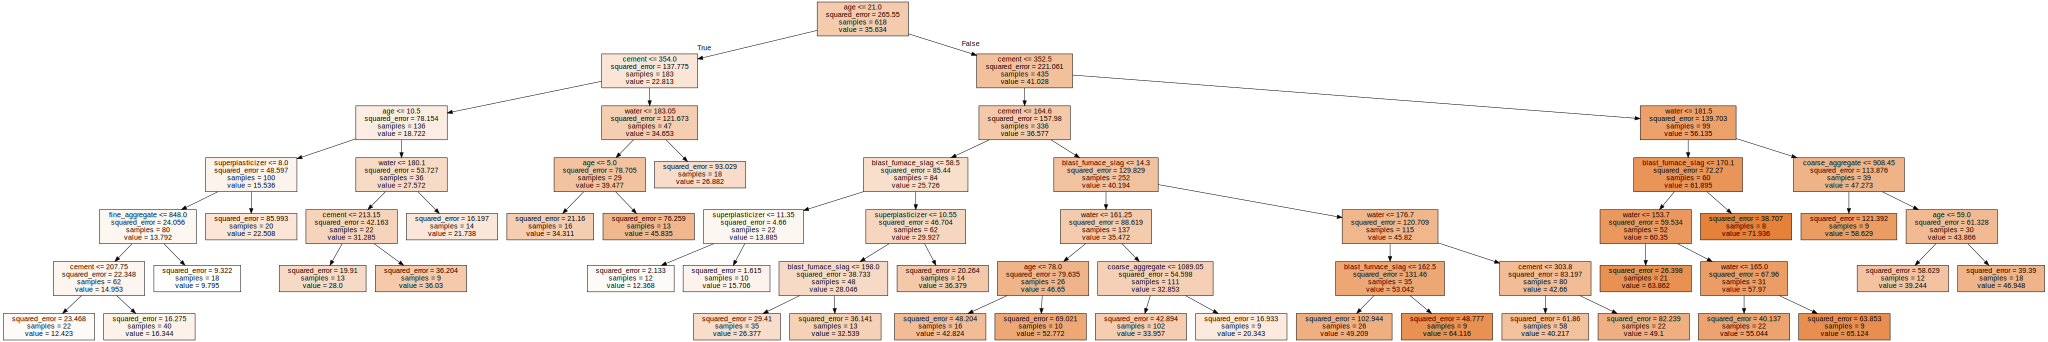

In [23]:
tree_graph = DecisionTreeRegressor(random_state=6659, min_samples_leaf=8, min_samples_split=22, max_depth=6)
tree_graph.fit(df_train_x,df_train_y)

export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names= v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### max_depth =6 을 추가한 뒤 전체 tree 구조를 시각화하였습니다. 

# 최종 모델

In [24]:
v_feature_name=df_train_x.columns
tree_final= DecisionTreeRegressor(min_samples_leaf=8, min_samples_split=22,max_depth=6, random_state=6659,)
tree_final.fit(df_train_x, df_train_y)


DecisionTreeRegressor(max_depth=6, min_samples_leaf=8, min_samples_split=22,
                      random_state=6659)

In [25]:
tree_final.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 22,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 6659,
 'splitter': 'best'}

In [26]:
print("Score on training set: {:.3f}".format(tree_final.score(df_train_x,df_train_y)))
print("Score on testing set: {:.3f}".format(tree_final.score(df_test_x,df_test_y)))

Score on training set: 0.829
Score on testing set: 0.760


#### 최종모델을 구축하여주고, 모델의 파라미터값을 확인해주었습니다.  최종 모델의 test score = 76%입니다. 모델의 성능은 낮기 때문에 모델을 어딘가에 사용하기에는 부적합하다고 판단됩니다. 제조업 기준에서는 81%성능은 넘어야합니다. 다른 파라미터나 데이터 전처리의 변화 등 여러가지 작업을 통해 모델의 성능을 향상시킬 수 있을 것이라고 판단됩니다.

In [27]:
test_pred= tree_final.predict(df_test_x)
pd.DataFrame({'실제값':df_test_y,'예측값':test_pred}).reset_index(drop=True)

,실제값,예측값
0,36.15,33.957059
1,78.80,55.043636
2,71.30,71.936250
3,65.91,58.628889
4,16.88,28.000000
...,...,...
407,44.28,40.216897
408,15.62,16.344500
409,52.01,45.834615
410,43.38,32.539231


#### 실제값과 예측값을 각각 비교해주었습니다. 크게 예측이 많이 벗어난 값은 별로 없었습니다.

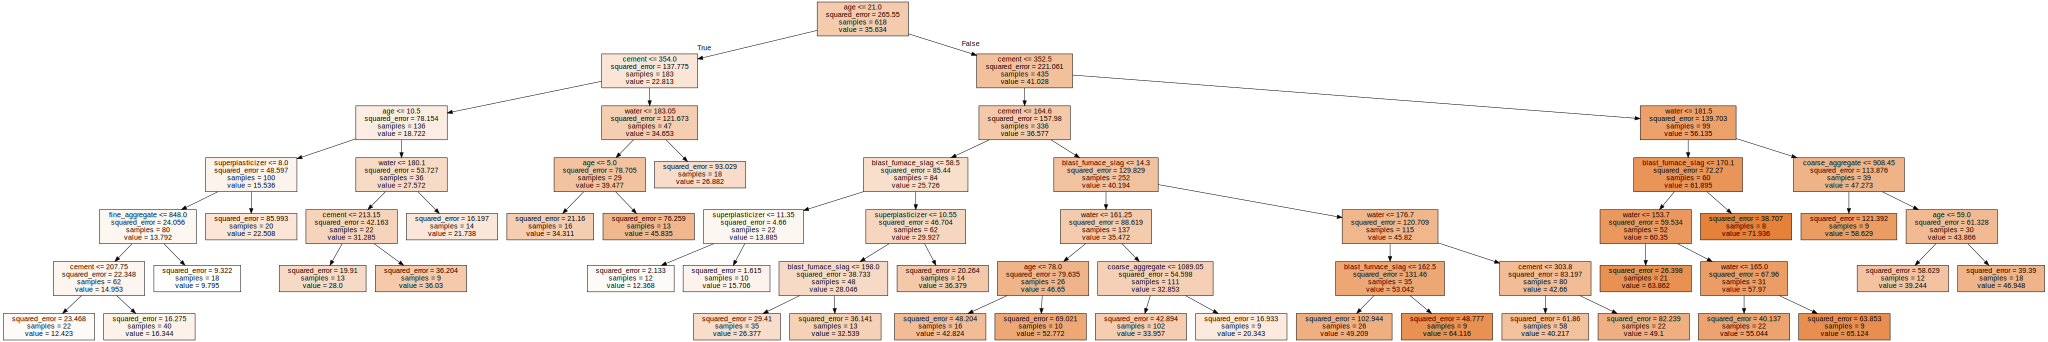

In [28]:
export_graphviz(tree_graph, out_file="tree_leaf.dot", feature_names= v_feature_name, impurity=True, filled=True)
with open("tree_leaf.dot") as f:
    dot_graph=f.read()
display(graphviz.Source(dot_graph))

#### 최종모델의 전체 tree 구조를 시각화해주고, 조건도 확인해주었습니다. 시멘트 강도가 가장 큰 값은 71.936이였다.  최초에 age <= 21이  False, cement<=352.5 , water <=181.5, blast_furnace_slag<=170.1로 나누어져서 squared_error가 38.07일때의 조건을 가질 때가 가장 컸다. 전체 트리 구조를 통해 확인할 수 있었다. 

In [29]:
df_importance=pd.DataFrame()
df_importance["Feature"]= v_feature_name
df_importance["importance"]= tree_final.feature_importances_

In [30]:
df_importance.sort_values("importance",ascending=False, inplace= True)
df_importance.round(3)

,Feature,importance
0,cement,0.390
7,age,0.357
3,water,0.113
1,blast_furnace_slag,0.100
5,coarse_aggregate,0.022
4,superplasticizer,0.015
6,fine_aggregate,0.003
2,fly_ash,0.000


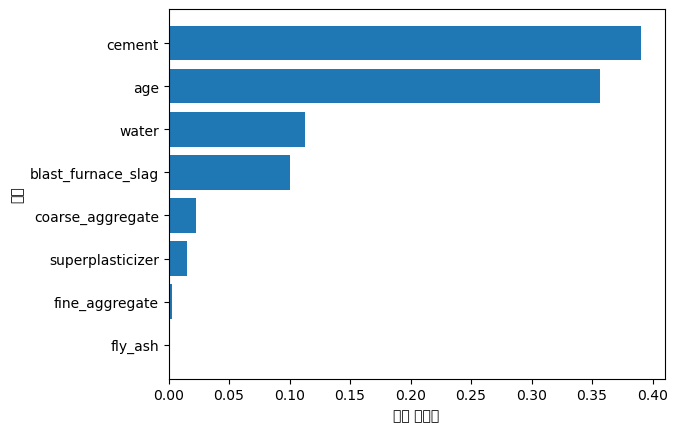

In [31]:
df_importance.sort_values("importance",ascending=True, inplace= True) 
coordinates= range(len(df_importance))
plt.barh(y= coordinates, width= df_importance["importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")
plt.show()

#### 변수 중요도를 확인하였습니다. 책에서 보았던 예시처럼 한 변수가 압도적이지 않고, blast_furnace_slag이 0.293으로 가장 높고, 순차적으로 strength, fly_ash, fine_aggregae, water, superplasticizer, age 로 거의 water까지 5개의 변수로 전체의 90% 이상 설명가능하다고 판단하였습니다.